# Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

from cryo_challenge._map_to_map.map_to_map_distance import scale_and_sum_normalization
from cryo_challenge._map_to_map.map_to_map_distance import normalize

Some methods require the map density to normalize to one (be on the simplex). This is not as trivial as it may seem. Exactly how this is done can affect downstream applications. This documentation acts as an appendix for these considerations

Map density map be arbitrarily scaled by an additive and multiplicative global constants:
$$
V_{ab} = aV + b \\
a,b \in \mathbb{R}
$$

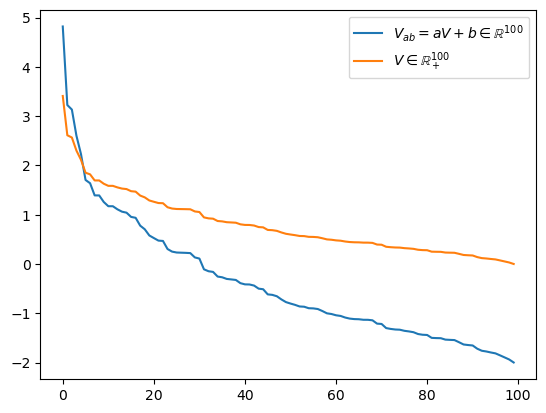

In [2]:
n_voxels = 100
torch.manual_seed(0)
v = torch.randn(n_voxels)
v = torch.abs(v)
v = torch.sort(v, descending=True).values
a = 2
b = -2
vab = a * v + b
plt.plot(vab, label=r"$V_{ab} = aV + b \in \mathbb{R}^{100}$")
plt.plot(v, label=r"$V \in \mathbb{R}_+^{100}$")
plt.legend()

We can normalize by shifting the minimum to zero, and dividing by the total intensity (now all positive), and this gives the same result

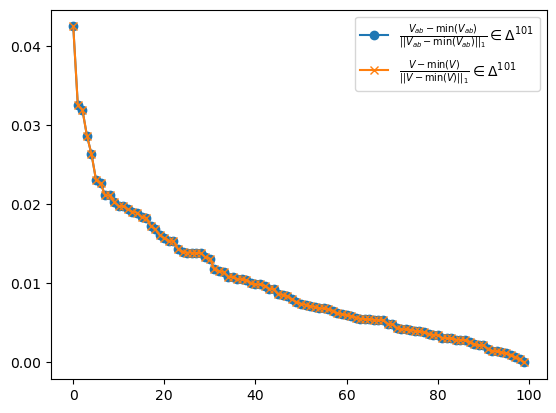

In [3]:
v_normed = scale_and_sum_normalization(v)
vab_normed = scale_and_sum_normalization(vab)
plt.plot(
    vab_normed,
    label=r"$\frac{V_{ab} - \min(V_{ab})}{||V_{ab} - \min(V_{ab})||_1}  \in \Delta^{101}$",
    marker="o",
)
plt.plot(
    v_normed,
    label=r"$\frac{V - \min(V)}{||V - \min(V)||_1}  \in \Delta^{101}$",
    marker="x",
)
plt.legend()
plt.show()

However, what happens when we have an outlier (in inteisty)?

While the unnormalized distrubiton is very similar, the noramlized values have a rather different scaling. 

This indicates that the normalization is not robust to outliers.

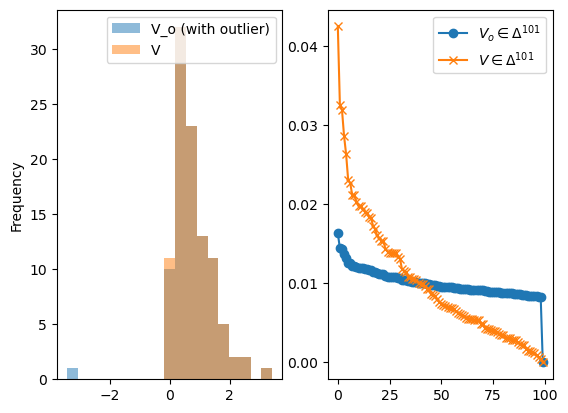

In [4]:
vo = v.clone()
vo[-1] = vo.min() - (vo.max() - vo.min())

n_voxels = 10


bin_min = min(v.min(), vo.min())
bin_max = max(v.max(), vo.max())
bins = torch.linspace(bin_min, bin_max, 20)

fig, axes = plt.subplots(1, 2)

pd.Series(vo).plot.hist(ax=axes[0], alpha=0.5, bins=bins, label="V_o (with outlier)")
pd.Series(v).plot.hist(ax=axes[0], alpha=0.5, bins=bins, label="V")
axes[0].legend()

v_normed = scale_and_sum_normalization(v)
vp_normed = scale_and_sum_normalization(vo)
axes[1].plot(vp_normed, label=r"$V_o  \in \Delta^{101}$", marker="o")
axes[1].plot(v_normed, label=r"$V  \in \Delta^{101}$", marker="x")
axes[1].legend()

We could quantify how far the normalizations are from each other by taking a Euclindean norm. This value is rather large. Could we pick another normalization that minimized it? Conversely, if we wanted to minimize it, what algorithm would do this?

Ref [1] derivates an algorithm that solves the following problem

$$
\min_{V^\prime \in \Delta^{n+1}} ||V^\prime-V||^2_2
$$

[1] Wang, W., & Carreira-Perpiñán, M. Á. (2013). Projection onto the probability simplex: An efficient algorithm with a simple proof, and an application, (2008), 1–5.

In [5]:
import torch


def euclidean_projection_simplex(y: torch.Tensor) -> torch.Tensor:
    """
    Projects a vector y onto the probability simplex.

    Args:
        y (torch.Tensor): Input tensor of shape (D,)

    Returns:
        torch.Tensor: Projected tensor onto the probability simplex
    """
    D = y.shape[0]
    u, _ = torch.sort(y, descending=True)
    cumsum_u = torch.cumsum(u, dim=0)

    rho = torch.nonzero(
        u + (1 / (torch.arange(1, D + 1, device=y.device))) * (1 - cumsum_u) > 0,
        as_tuple=True,
    )[0].max()
    lambda_ = (1 - cumsum_u[rho]) / (rho + 1)

    return torch.maximum(y + lambda_, torch.tensor(0.0, device=y.device))


veps = euclidean_projection_simplex(v)
vabeps = euclidean_projection_simplex(vab)
voeps = euclidean_projection_simplex(vo)

In [6]:
import numpy as np


def projection_simplex_sort(v, z=1):
    """https://gist.github.com/mblondel/6f3b7aaad90606b98f71#file-projection_simplex-py-L19
    https://github.com/ma-gilles/wilson_prior/blob/61605937b40c296778c1b1c52ce1d3ce633cb8fd/priors.py#L67
    """
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


torch.allclose(projection_simplex_sort(vo), euclidean_projection_simplex(vo))

True

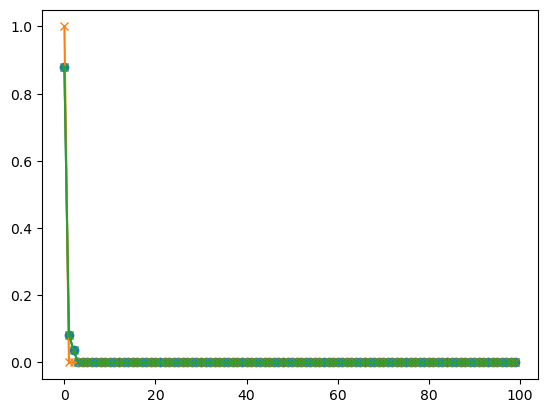

In [7]:
plt.plot(veps, label=r"$V_o  \in \Delta^{101}$", marker="o")
plt.plot(vabeps, label=r"$V  \in \Delta^{101}$", marker="x")
plt.plot(voeps, label=r"$V  \in \Delta^{101}$", marker="x")

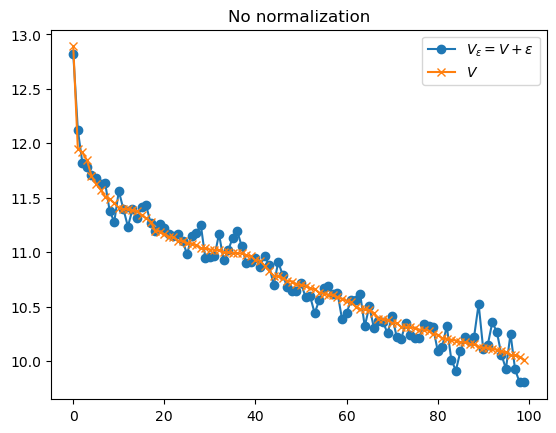

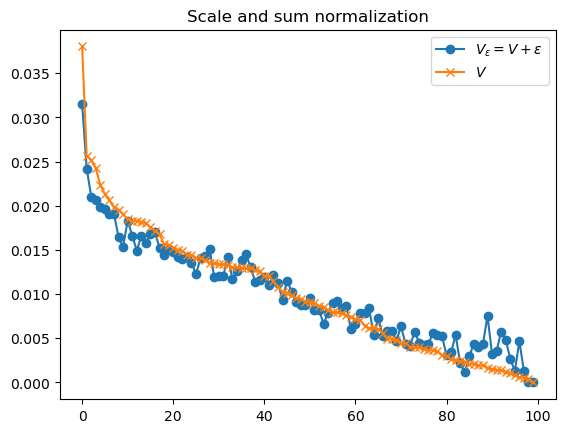

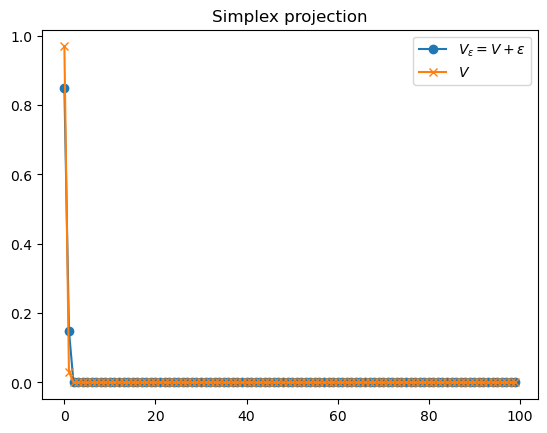

In [8]:
n_voxels = 100
v = torch.randn(n_voxels)
v = torch.abs(v)
v = torch.sort(v, descending=True).values + 10

noise = torch.randn(n_voxels) * 0.1
vn = v + noise
plt.plot(vn, label=r"$V_{\epsilon} = V + \epsilon$", marker="o")
plt.plot(v, label=r"$V$", marker="x")
plt.legend()
plt.title("No normalization")
plt.show()

plt.plot(
    scale_and_sum_normalization(vn), label=r"$V_{\epsilon} = V + \epsilon$", marker="o"
)
plt.plot(scale_and_sum_normalization(v), label=r"$V$", marker="x")
plt.title("Scale and sum normalization")
plt.legend()
plt.show()


plt.plot(
    euclidean_projection_simplex(vn), label=r"$V_{\epsilon} = V + \epsilon$", marker="o"
)
plt.plot(euclidean_projection_simplex(v), label=r"$V$", marker="x")
plt.title("Simplex projection")
plt.legend()
plt.show()

In [9]:
from cryo_challenge._map_to_map.map_to_map_distance import vectorized_simplex_projection

Y = torch.stack([v, vn])
X = vectorized_simplex_projection(Y)
assert torch.allclose(euclidean_projection_simplex(v), X[0])
assert torch.allclose(euclidean_projection_simplex(vn), X[1])

# Performance on volumes

In [10]:
fname = "/mnt/home/smbp/ceph/smbpchallenge/round2/set2/processed_submissions/submission_23.pt"
submission = torch.load(fname, weights_only=False)

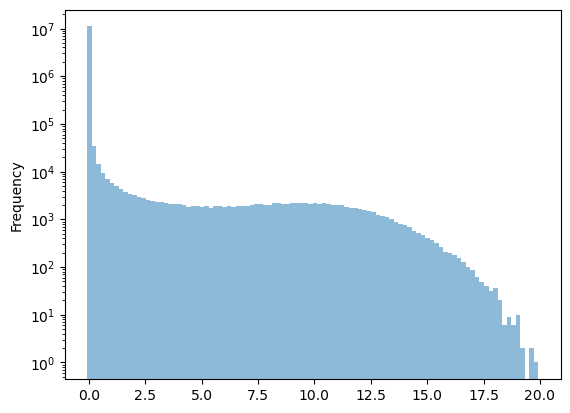

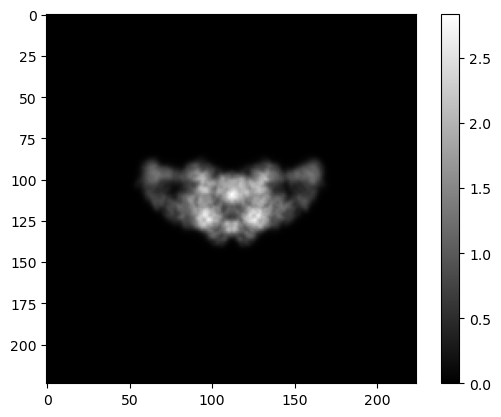

In [11]:
idx = 0
maps = submission["volumes"]
pd.Series(maps[idx].flatten()).plot.hist(bins=100, alpha=0.5, label="V", logy=True)
plt.show()
plt.imshow(maps[idx].mean(2), cmap="gray")
plt.colorbar()

In [12]:
n = 3
maps_scale_and_sum = normalize(
    maps[:n].clone().reshape(n, -1), method="scale_and_sum"
).reshape(submission["volumes"][:n].shape)

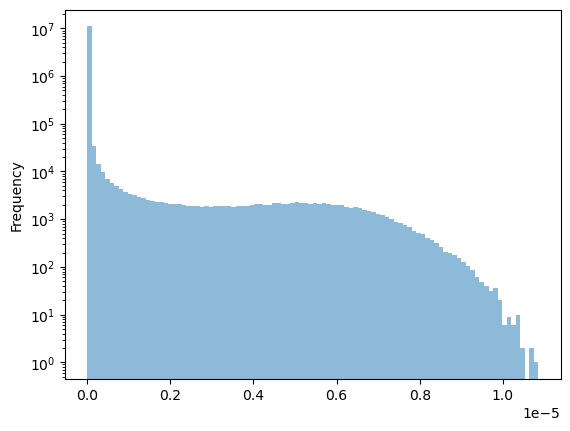

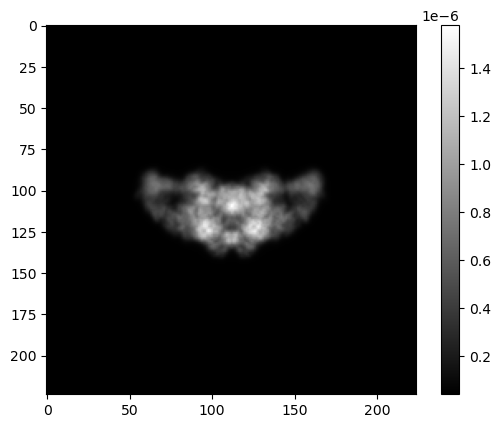

In [13]:
idx = 0

pd.Series(maps_scale_and_sum[idx].flatten()).plot.hist(
    bins=100, alpha=0.5, label="V", logy=True
)
plt.show()
plt.imshow(maps_scale_and_sum[idx].mean(2), cmap="gray")
plt.colorbar()

In [14]:
additive_offset = 10
maps_simplex_projection = normalize(
    maps_scale_and_sum.clone() + additive_offset, method="simplex_projection"
)

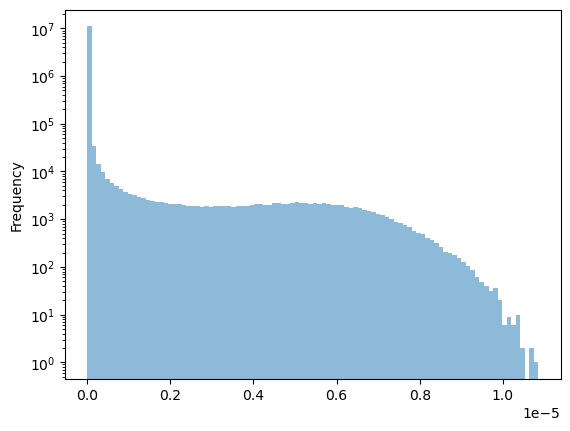

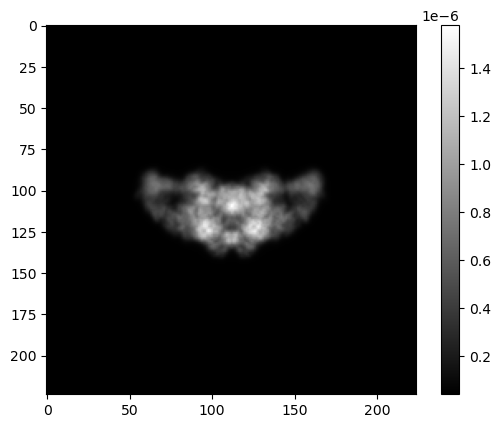

In [15]:
pd.Series(maps_scale_and_sum[idx].flatten()).plot.hist(
    bins=100, alpha=0.5, label="V", logy=True
)
plt.show()
plt.imshow(maps_scale_and_sum[idx].mean(2), cmap="gray")
plt.colorbar()

We can solve the more general problem:

$$
\min_{V^\prime \in \Delta^{n+1}, a \in \mathbb{R}_+, b \in \mathbb{R}} ||V^\prime-aV+b||^2_2
$$

In [59]:
import cvxpy as cp

# Define problem dimensions
n = len(v) - 1  # Example size, can be adjusted
V = v.clone()  # np.random.randn(n+1)  # Example V vector
# V[-3:] = V.min() - (V.max() - V.min())

# Define variables
V_prime = cp.Variable(n + 1)
a = cp.Variable(nonneg=True)  # a >= 0
b = cp.Variable()

# Define objective function
objective = cp.Minimize(cp.norm(V_prime - a * V + b, 1) ** 2)

# Define constraints
constraints = [
    cp.sum(V_prime) == 1,  # Probability simplex constraint
    V_prime >= 0,  # Non-negativity constraint
    # cp.sum(a * V + b) == 1,
]

# Define and solve the problem
problem = cp.Problem(
    objective,
    constraints,
)
problem.solve(solver="CLARABEL", verbose=True)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Mar 13 06:35:02 PM: Your problem has 102 variables, 101 constraints, and 0 parameters.
(CVXPY) Mar 13 06:35:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 13 06:35:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 13 06:35:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 13 06:35:02 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 13 06:35:02 PM: Compiling problem (target solver=CLARABEL

2.1018298062136372e-11

0.0125427317741929


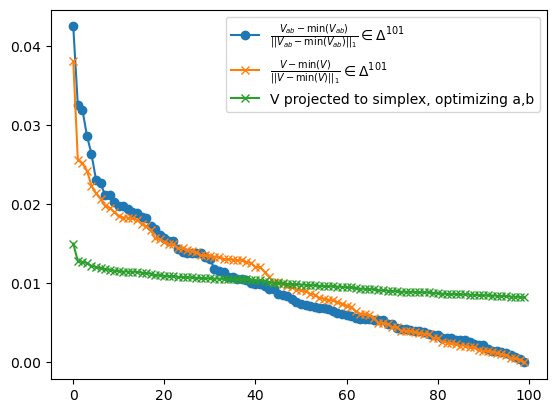

In [ ]:
v_normed = scale_and_sum_normalization(v)
vab_normed = scale_and_sum_normalization(vab)
print(cp.norm(v_normed - vab_normed, 1).value ** 2)
plt.plot(
    vab_normed,
    label=r"$\frac{V_{ab} - \min(V_{ab})}{||V_{ab} - \min(V_{ab})||_1}  \in \Delta^{101}$",
    marker="o",
)
plt.plot(
    v_normed,
    label=r"$\frac{V - \min(V)}{||V - \min(V)||_1}  \in \Delta^{101}$",
    marker="x",
)
plt.plot(
    V_prime.value,
    label="V projected to simplex, also optimizing a,b",
    marker="x",
)
plt.legend()
plt.show()

# Manual check of submissions

In [61]:
from glob import glob
from natsort import natsorted
import os

num_to_flabour_dict = {
    # round 2
    12: "Neapolitan 2",
    21: "Salted Caramel 2",
    20: "Rocky Road 2",
    23: "Mint Chocolate Chip 1",
    16: "Vanilla 2",
    15: "Cherry 2",
    26: "Salted Caramel 5",
    24: "Bubble Gum 1",
    25: "Salted Caramel 4",
    19: "Rocky Road 3",
    14: "Pina Colada 1",
    22: "Salted Caramel 3",
    18: "Peanut Butter 2",
    13: "Chocolate 2",
    29: "test_mango_identical",
    17: "Cookie Dough 2",
    99: "Noise",
    # round 1
    4: "Neapolitan",
    6: "Rocky Road",
    7: "Peanut Butter",
    2: "Black Raspberry",
    10: "Mango",
    9: "Vanilla",
    8: "Chocolate Chip",
    5: "Cookie Dough",
    1: "Salted Caramel",
    3: "Chocolate",
    11: "Cherry",
    0: "Coffee",
}

submissions_d = {}

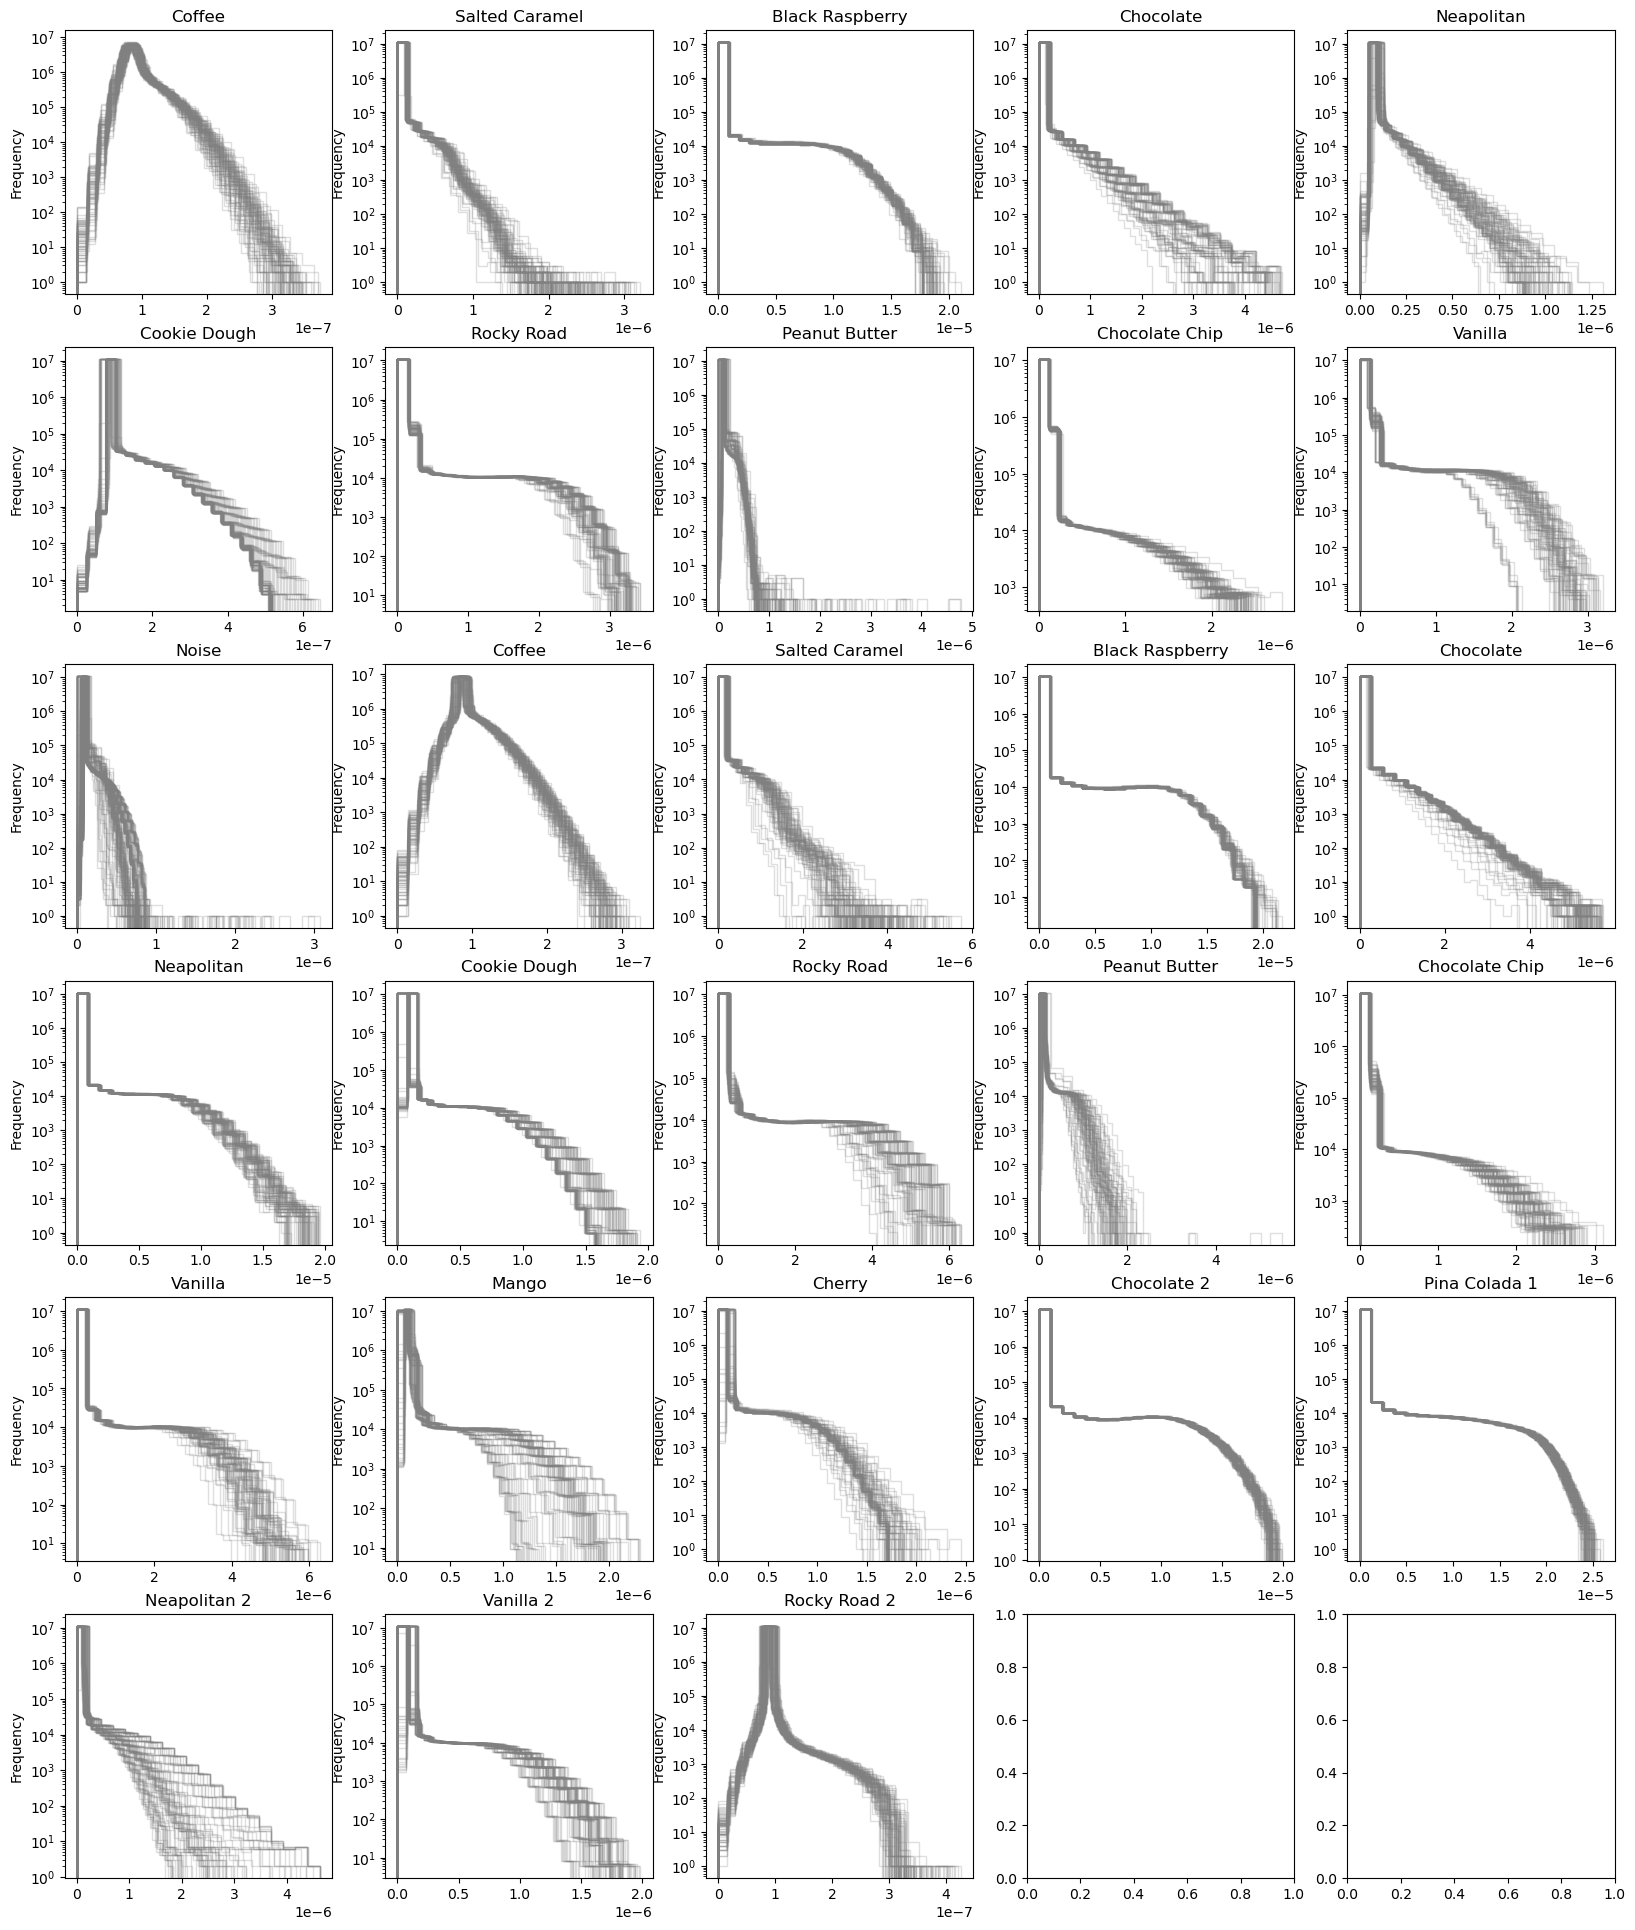

In [62]:
nr = 6
nc = 5
n_subs = nr * nc
base = 4
submissions = natsorted(
    glob(
        "/mnt/home/smbp/ceph/smbpchallenge/round?/set?/processed_submissions/submission_*.pt"
    )[:n_subs]
)

fix, axes = plt.subplots(nr, nc, figsize=(base * nc, base * nr))
plot_idx = 0
for fname in submissions:
    num = int(os.path.basename(fname).split("_")[1].split(".")[0])
    if num not in num_to_flabour_dict or not os.path.isfile(fname):
        plot_idx -= 1
        continue
    flavour = num_to_flabour_dict[num]
    plt_row = plot_idx // nc
    plt_col = plot_idx % nc
    axes[plt_row, plt_col].set_title(flavour)

    if fname in submissions_d:
        print(f"Skipping {fname}")
    else:
        submission = torch.load(fname, weights_only=False)
        submissions_d[fname] = submission
    maps = submission["volumes"]
    n_vols = maps.shape[0]

    maps_scale_and_sum = normalize(
        maps.clone().reshape(n_vols, -1), method="scale_and_sum"
    ).reshape(maps.shape)
    for idx in range(n_vols):
        pd.Series(maps_scale_and_sum[idx].flatten()).plot.hist(
            bins=20,
            alpha=0.25,
            label="V",
            color="gray",
            logy=True,
            ax=axes[plt_row, plt_col],
            histtype="step",
        )
    plot_idx += 1